In [7]:
# %%
# Import necessary libraries for data manipulation, visualization, and modeling.
import os                      # For file system operations (listing CSV files)
import pandas as pd            # For data manipulation and analysis
import numpy as np             # For numerical computations
import matplotlib.pyplot as plt  # For plotting charts and plots
from sklearn.ensemble import RandomForestRegressor  # For using Random Forest Regressor algorithm
from sklearn.metrics import mean_squared_error      # For evaluating model performance (MSE)


In [8]:
def load_intervals(reference_csv):
    """
    Load hydrocarbon and water depth intervals from a reference CSV file.
    
    Parameters:
    - reference_csv (str): Path to the reference CSV file containing depth intervals.
    
    Returns:
    - hydrocarbon_intervals (dict): A dictionary mapping well names to lists of tuples for hydrocarbon intervals.
    - water_intervals (dict): A dictionary mapping well names to lists of tuples for water intervals.
    """
    df_intervals = pd.read_csv(reference_csv, header=None)
    
    # Initialize dictionaries to hold intervals
    hydrocarbon_intervals = {}
    water_intervals = {}
    
    # Define markers for hydrocarbons and water
    hydrocarbon_markers = ['GUT', 'GDT', 'GOC', 'OUT', 'ODT']
    water_markers = ['OWC', 'WUT', 'WDT']
    
    # Iterate through the DataFrame to extract intervals
    for col in range(1, df_intervals.shape[1]):  # Skip the first column (well names)
        well_name = df_intervals.iloc[0, col]  # First row contains well names
        if well_name not in hydrocarbon_intervals:
            hydrocarbon_intervals[well_name] = []
        if well_name not in water_intervals:
            water_intervals[well_name] = []
        
        for row in range(1, df_intervals.shape[0]):  # Skip the first row (header)
            marker = df_intervals.iloc[row, 0]  # First column contains markers
            depth = df_intervals.iloc[row, col]  # Depth for the current well and marker
            
            if pd.notna(depth):  # Check if depth is not empty
                if marker in hydrocarbon_markers:
                    hydrocarbon_intervals[well_name].append((depth, depth))  # Use the same depth for top and bottom
                elif marker in water_markers:
                    water_intervals[well_name].append((depth, depth))  # Use the same depth for top and bottom
    
    return hydrocarbon_intervals, water_intervals

def is_within_intervals(depth, intervals):
    """Check if the given depth is within any of the specified intervals."""
    try:
        depth = float(depth)
    except ValueError:
        print(f"Invalid depth value: {depth}")  # Debugging output
        return False

    for top, bottom in intervals:
        print(f"Checking if {depth} is between {top} and {bottom}")  # Debugging output
        if float(top) <= depth <= float(bottom):
            return True
    return False


def determine_fluid_type(depth, hydrocarbon_intervals, water_intervals):
    """Determine the fluid type for a given depth."""
    if is_within_intervals(depth, hydrocarbon_intervals):
        return 'Hydrocarbon'
    elif is_within_intervals(depth, water_intervals):
        return 'Water'
    else:
        return 'Non-fluid'

def predict_RT_random_forest(data_directory, reference_csv, random_state=42, n_estimators=300):
    """
    This function reads multiple CSV files from the given data_directory where each CSV file represents 
    well data of petrophysical properties. It then trains a Random Forest regression model using DEPT (depth), 
    GR (gamma ray), and fluid type features as predictors and RT (resistivity) as the target variable 
    from all wells except well "AK-9". Afterwards, it uses the trained model to predict the RT for well "AK-9" 
    and plots the predicted RT curve.

    Parameters:
    - data_directory (str): The directory where the well CSV files are stored.
    - reference_csv (str): Path to the reference CSV file containing depth intervals.
    - random_state (int): A seed to ensure that the results are reproducible.
    - n_estimators (int): The number of trees to build in the Random Forest. 

    Returns:
    - rf_model: The trained RandomForestRegressor() model.
    - ak9_pred_df: A DataFrame that contains the well AK-9's DEPT, GR, and the predicted RT values.
    - mse (float): The Mean Squared Error on the training data (diagnostic metric).
    """
    
    # Load hydrocarbon and water intervals from the reference CSV
    hydrocarbon_intervals, water_intervals = load_intervals(reference_csv)
    
    # Print the intervals for verification
    print("Hydrocarbon Intervals:", hydrocarbon_intervals)
    print("Water Intervals:", water_intervals)

    # Dictionary to store data from each CSV file.
    wells_data = {}
    
    # Loop over every CSV file in the specified directory.
    for filename in os.listdir(data_directory):
        if filename.lower().endswith('.csv'):
            well_name = os.path.splitext(filename)[0]
            file_path = os.path.join(data_directory, filename)
            try:
                df = pd.read_csv(file_path)
                df['Well'] = well_name  # Add a column to identify the well
                wells_data[well_name] = df
            except Exception as e:
                print(f"Error reading file {filename}: {e}")

    if "AK-9" not in wells_data:
        raise ValueError("AK-9 CSV file not found in the directory.")

    train_X_list = []
    train_y_list = []
    
    for well, df in wells_data.items():
        if well == ["AK-9"]:
            continue
        if not set(['DEPT', 'GR', 'RT']).issubset(df.columns):
            print(f"Warning: Well {well} does not contain the required columns. Skipping.")
            continue
        
        # Determine fluid type for each depth in the DataFrame
        df['Fluid_Type'] = df['DEPT'].apply(lambda x: determine_fluid_type(x, hydrocarbon_intervals.get(well, []), water_intervals.get(well, [])))
        
        # Create binary features for fluid types
        df['In_Hydrocarbon_Interval'] = df['Fluid_Type'].apply(lambda x: 1 if x == 'Hydrocarbon' else 0)
        df['In_Water_Interval'] = df['Fluid_Type'].apply(lambda x: 1 if x == 'Water' else 0)
        
        # Keep only the columns of interest and drop any rows with missing values.
        df_clean = df[['DEPT', 'GR', 'RT', 'In_Hydrocarbon_Interval', 'In_Water_Interval']].dropna()
        train_X_list.append(df_clean[['DEPT', 'GR', 'In_Hydrocarbon_Interval', 'In_Water_Interval']])
        train_y_list.append(df_clean['RT'])
    
    if len(train_X_list) == 0:
        raise ValueError("No training data available. Check your CSV files and column names.")

    X_train = pd.concat(train_X_list, ignore_index=True)
    y_train = pd.concat(train_y_list, ignore_index=True)
    
    print("Training data shape:", X_train.shape)
    
    # Create and train the Random Forest model.
    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    rf_model.fit(X_train, y_train)
    
    # For diagnostics: Evaluate performance on training data with Mean Squared Error.
    y_train_pred = rf_model.predict(X_train)
    mse = mean_squared_error(y_train, y_train_pred)
    print("Training MSE: {:.4f}".format(mse))
    
    # Prepare the test data from well "AK-9".
    ak9_df = wells_data["AK-9"]
    
    # Make sure the required columns (DEPT and GR) exist in AK-9's data.
    if not set(['DEPT', 'GR']).issubset(ak9_df.columns):
        raise ValueError("AK-9 CSV file must have at least DEPT and GR columns.")
    
    # Determine fluid type for each depth in AK-9
    ak9_df['Fluid_Type'] = ak9_df['DEPT'].apply(lambda x: determine_fluid_type(x, hydrocarbon_intervals.get("AK-9", []), water_intervals.get("AK-9", [])))
    ak9_df['In_Hydrocarbon_Interval'] = ak9_df['Fluid_Type'].apply(lambda x: 1 if x == 'Hydrocarbon' else 0)
    ak9_df['In_Water_Interval'] = ak9_df['Fluid_Type'].apply(lambda x: 1 if x == 'Water' else 0)
    
    # Use only the DEPT, GR, and fluid type columns from AK-9 and drop rows with missing data.
    ak9_test = ak9_df[['DEPT', 'GR', 'In_Hydrocarbon_Interval', 'In_Water_Interval']].dropna().reset_index(drop=True)
    
    # Predict RT (resistivity) for AK-9 using the trained model.
    ak9_pred = rf_model.predict(ak9_test)
    
    # Combine the test data with the predicted RT values.
    ak9_pred_df = ak9_test.copy()
    ak9_pred_df['Predicted_RT'] = ak9_pred

    # Plot the predicted resistivity (RT) curve vs. depth (DEPT) for visual diagnostic.
    plt.figure(figsize=(6, 8))
    plt.plot(ak9_pred_df['Predicted_RT'], ak9_pred_df['DEPT'], label='Predicted RT', color='b')
    plt.gca().invert_yaxis()  # Depth typically increases downward.
    plt.xlabel("Resistivity (RT)")
    plt.ylabel("Depth (DEPT)")
    plt.title("Predicted RT Curve for AK-9")
    plt.legend()
    plt.grid(True)
    plt.xscale('log')
    plt.grid(which='minor', color='gray', linestyle='--', linewidth=0.5) 
    plt.grid(which='major', color='black', linestyle='-', linewidth=0.75) 
    plt.minorticks_on()
    plt.xlim(0, 2000)
    plt.show()
    
    # Return the trained model, the predictions dataframe for AK-9, and MSE value.
    return rf_model, ak9_pred_df, mse

# Example usage:
# data_directory = "path/to/well/data"
# reference_csv = "path/to/reference_intervals.csv"
# model, predictions, error = predict_RT_random_forest(data_directory, reference_csv)


Hydrocarbon Intervals: {'AK-1': [('4838', '4838'), ('5031', '5031'), ('5088', '5088'), ('5184', '5184')], 'AK-2': [('5114', '5114'), ('5168', '5168'), ('5198', '5198')], 'AK-3': [('5121', '5121'), ('5197', '5197'), ('5121', '5121'), ('5164', '5164'), ('5258', '5258')], 'AK-4': [('5014', '5014'), ('5105', '5105'), ('5141', '5141'), ('5166', '5166'), ('5258', '5258')], 'AK-5': [('5063', '5063'), ('5168', '5168')], 'AK-6': [('5136', '5136'), ('5156', '5156'), ('5188', '5188'), ('5320', '5320')], 'AK-7': [('5503', '5503'), ('5530', '5530')], 'AK-8ST2': [('5081', '5081'), ('5165', '5165')], 'AK-9': [('5088', '5088'), ('5165', '5165')], 'AK-10': [('5237', '5237'), ('5259', '5259'), ('5346', '5346')], 'AK-11': [], 'AK-12': [], 'AK-13': [], 'AK-14': [('5262', '5262')], 'AK-15P': [('5017', '5017'), ('5183', '5183')]}
Water Intervals: {'AK-1': [('5121', '5121'), ('5142', '5142'), ('5274', '5274'), ('5317', '5317')], 'AK-2': [('5201', '5201'), ('5204', '5204'), ('5312', '5312'), ('5348', '5348'),

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Checking if 3603.2595 is between 5289 and 5289
Checking if 3603.2595 is between 5330 and 5330
Checking if 3603.2595 is between 5413 and 5413
Checking if 3603.2595 is between 5447 and 5447
Checking if 3603.2595 is between 5599 and 5599
Checking if 3603.68285 is between 5088 and 5088
Checking if 3603.68285 is between 5165 and 5165
Checking if 3603.68285 is between 5198 and 5198
Checking if 3603.68285 is between 5289 and 5289
Checking if 3603.68285 is between 5330 and 5330
Checking if 3603.68285 is between 5413 and 5413
Checking if 3603.68285 is between 5447 and 5447
Checking if 3603.68285 is between 5599 and 5599
Checking if 3604.1062 is between 5088 and 5088
Checking if 3604.1062 is between 5165 and 5165
Checking if 3604.1062 is between 5198 and 5198
Checking if 3604.1062 is between 5289 and 5289
Checking if 3604.1062 is between 5330 and 5330
Checking if 3604.1062 is between 5413 and 5413
Checking if 3604.1062 is between 5447 and 5447
Checking if 3604.1062 is between 5599 and 5599
Chec

Training MSE: 145.4412
Checking if 3497.4220000000005 is between 5088 and 5088
Checking if 3497.4220000000005 is between 5165 and 5165
Checking if 3497.4220000000005 is between 5198 and 5198
Checking if 3497.4220000000005 is between 5289 and 5289
Checking if 3497.4220000000005 is between 5330 and 5330
Checking if 3497.4220000000005 is between 5413 and 5413
Checking if 3497.4220000000005 is between 5447 and 5447
Checking if 3497.4220000000005 is between 5599 and 5599
Checking if 3497.84535 is between 5088 and 5088
Checking if 3497.84535 is between 5165 and 5165
Checking if 3497.84535 is between 5198 and 5198
Checking if 3497.84535 is between 5289 and 5289
Checking if 3497.84535 is between 5330 and 5330
Checking if 3497.84535 is between 5413 and 5413
Checking if 3497.84535 is between 5447 and 5447
Checking if 3497.84535 is between 5599 and 5599
Checking if 3498.2687 is between 5088 and 5088
Checking if 3498.2687 is between 5165 and 5165
Checking if 3498.2687 is between 5198 and 5198
Chec

/tmp/ipykernel_13518/2315530946.py:185: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 2000)


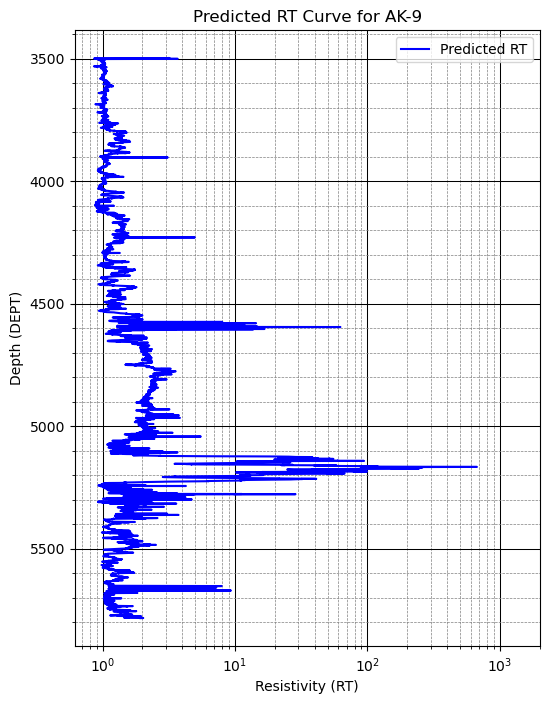

First few predictions for Well AK-9:
         DEPT       GR  In_Hydrocarbon_Interval  In_Water_Interval  \
0  3497.42200  61.8172                        0                  0   
1  3497.84535  61.7498                        0                  0   
2  3498.26870  63.5458                        0                  0   
3  3498.69205  65.9944                        0                  0   
4  3499.11540  68.4277                        0                  0   
5  3499.53875  70.0881                        0                  0   
6  3499.96210  71.1977                        0                  0   
7  3500.38545  72.1716                        0                  0   
8  3500.80880  74.0863                        0                  0   
9  3501.23215  76.6759                        0                  0   

   Predicted_RT  
0      3.188437  
1      3.186042  
2      1.856660  
3      1.722135  
4      0.862697  
5      0.974778  
6      1.675026  
7      3.694036  
8      1.140745  
9      0.928

In [9]:
# %%
# Set the path to the directory that contains the CSV files with the well data.
# Adjust this path to point to the correct directory on your machine.
data_directory = "/home/nuevacomp/PetroNativeAI/Use Cases/Petrophysics/Published on Github"
reference_csv = "/home/nuevacomp/PetroNativeAI/Use Cases/Petrophysics/Published on Github/AK_contacts.csv"

# Run our function to train the model and make predictions for well "AK-9"
model, ak9_predictions, training_mse = predict_RT_random_forest(data_directory, reference_csv, random_state=42, n_estimators=300)

# Print the first few rows of the predictions DataFrame to check the results.
print("First few predictions for Well AK-9:")
print(ak9_predictions.head(10))


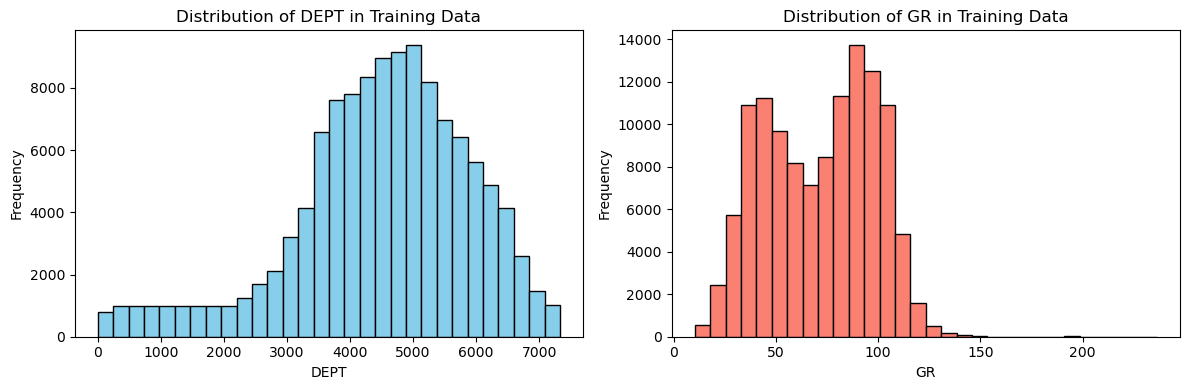

In [10]:
# %%
# This cell is optional but helps you visualize the distribution of the training data.
# We will reconstruct X_train from the previously processed CSV files.

# Create lists to hold the training features.
train_X_list = []
for filename in os.listdir(data_directory):
    if filename.lower().endswith('.csv'):
        well_name = os.path.splitext(filename)[0]
        # Skip AK-9 for training features.
        if well_name == ["AK-9"]:          
            continue
        file_path = os.path.join(data_directory, filename)
        try:
            df = pd.read_csv(file_path)
            # Ensure the required columns exist.
            if set(['DEPT', 'GR', 'RT']).issubset(df.columns):
                df_clean = df[['DEPT', 'GR']].dropna()
                train_X_list.append(df_clean)
        except Exception as e:
            print(f"Error reading file {filename}: {e}")
            
# If any training data was loaded, concatenate and plot
if train_X_list:
    X_train_full = pd.concat(train_X_list, ignore_index=True)
    
    # Plot histogram for DEPT
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(X_train_full['DEPT'], bins=30, color='skyblue', edgecolor='black')
    plt.xlabel("DEPT")
    plt.ylabel("Frequency")
    plt.title("Distribution of DEPT in Training Data")
    
    # Plot histogram for GR
    plt.subplot(1, 2, 2)
    plt.hist(X_train_full['GR'], bins=30, color='salmon', edgecolor='black')
    plt.xlabel("GR")
    plt.ylabel("Frequency")
    plt.title("Distribution of GR in Training Data")
    
    plt.tight_layout()
    plt.show()
else:
    print("No training data available for visualization.")


/tmp/ipykernel_13518/2404691070.py:93: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[1].set_xlim(0,100)


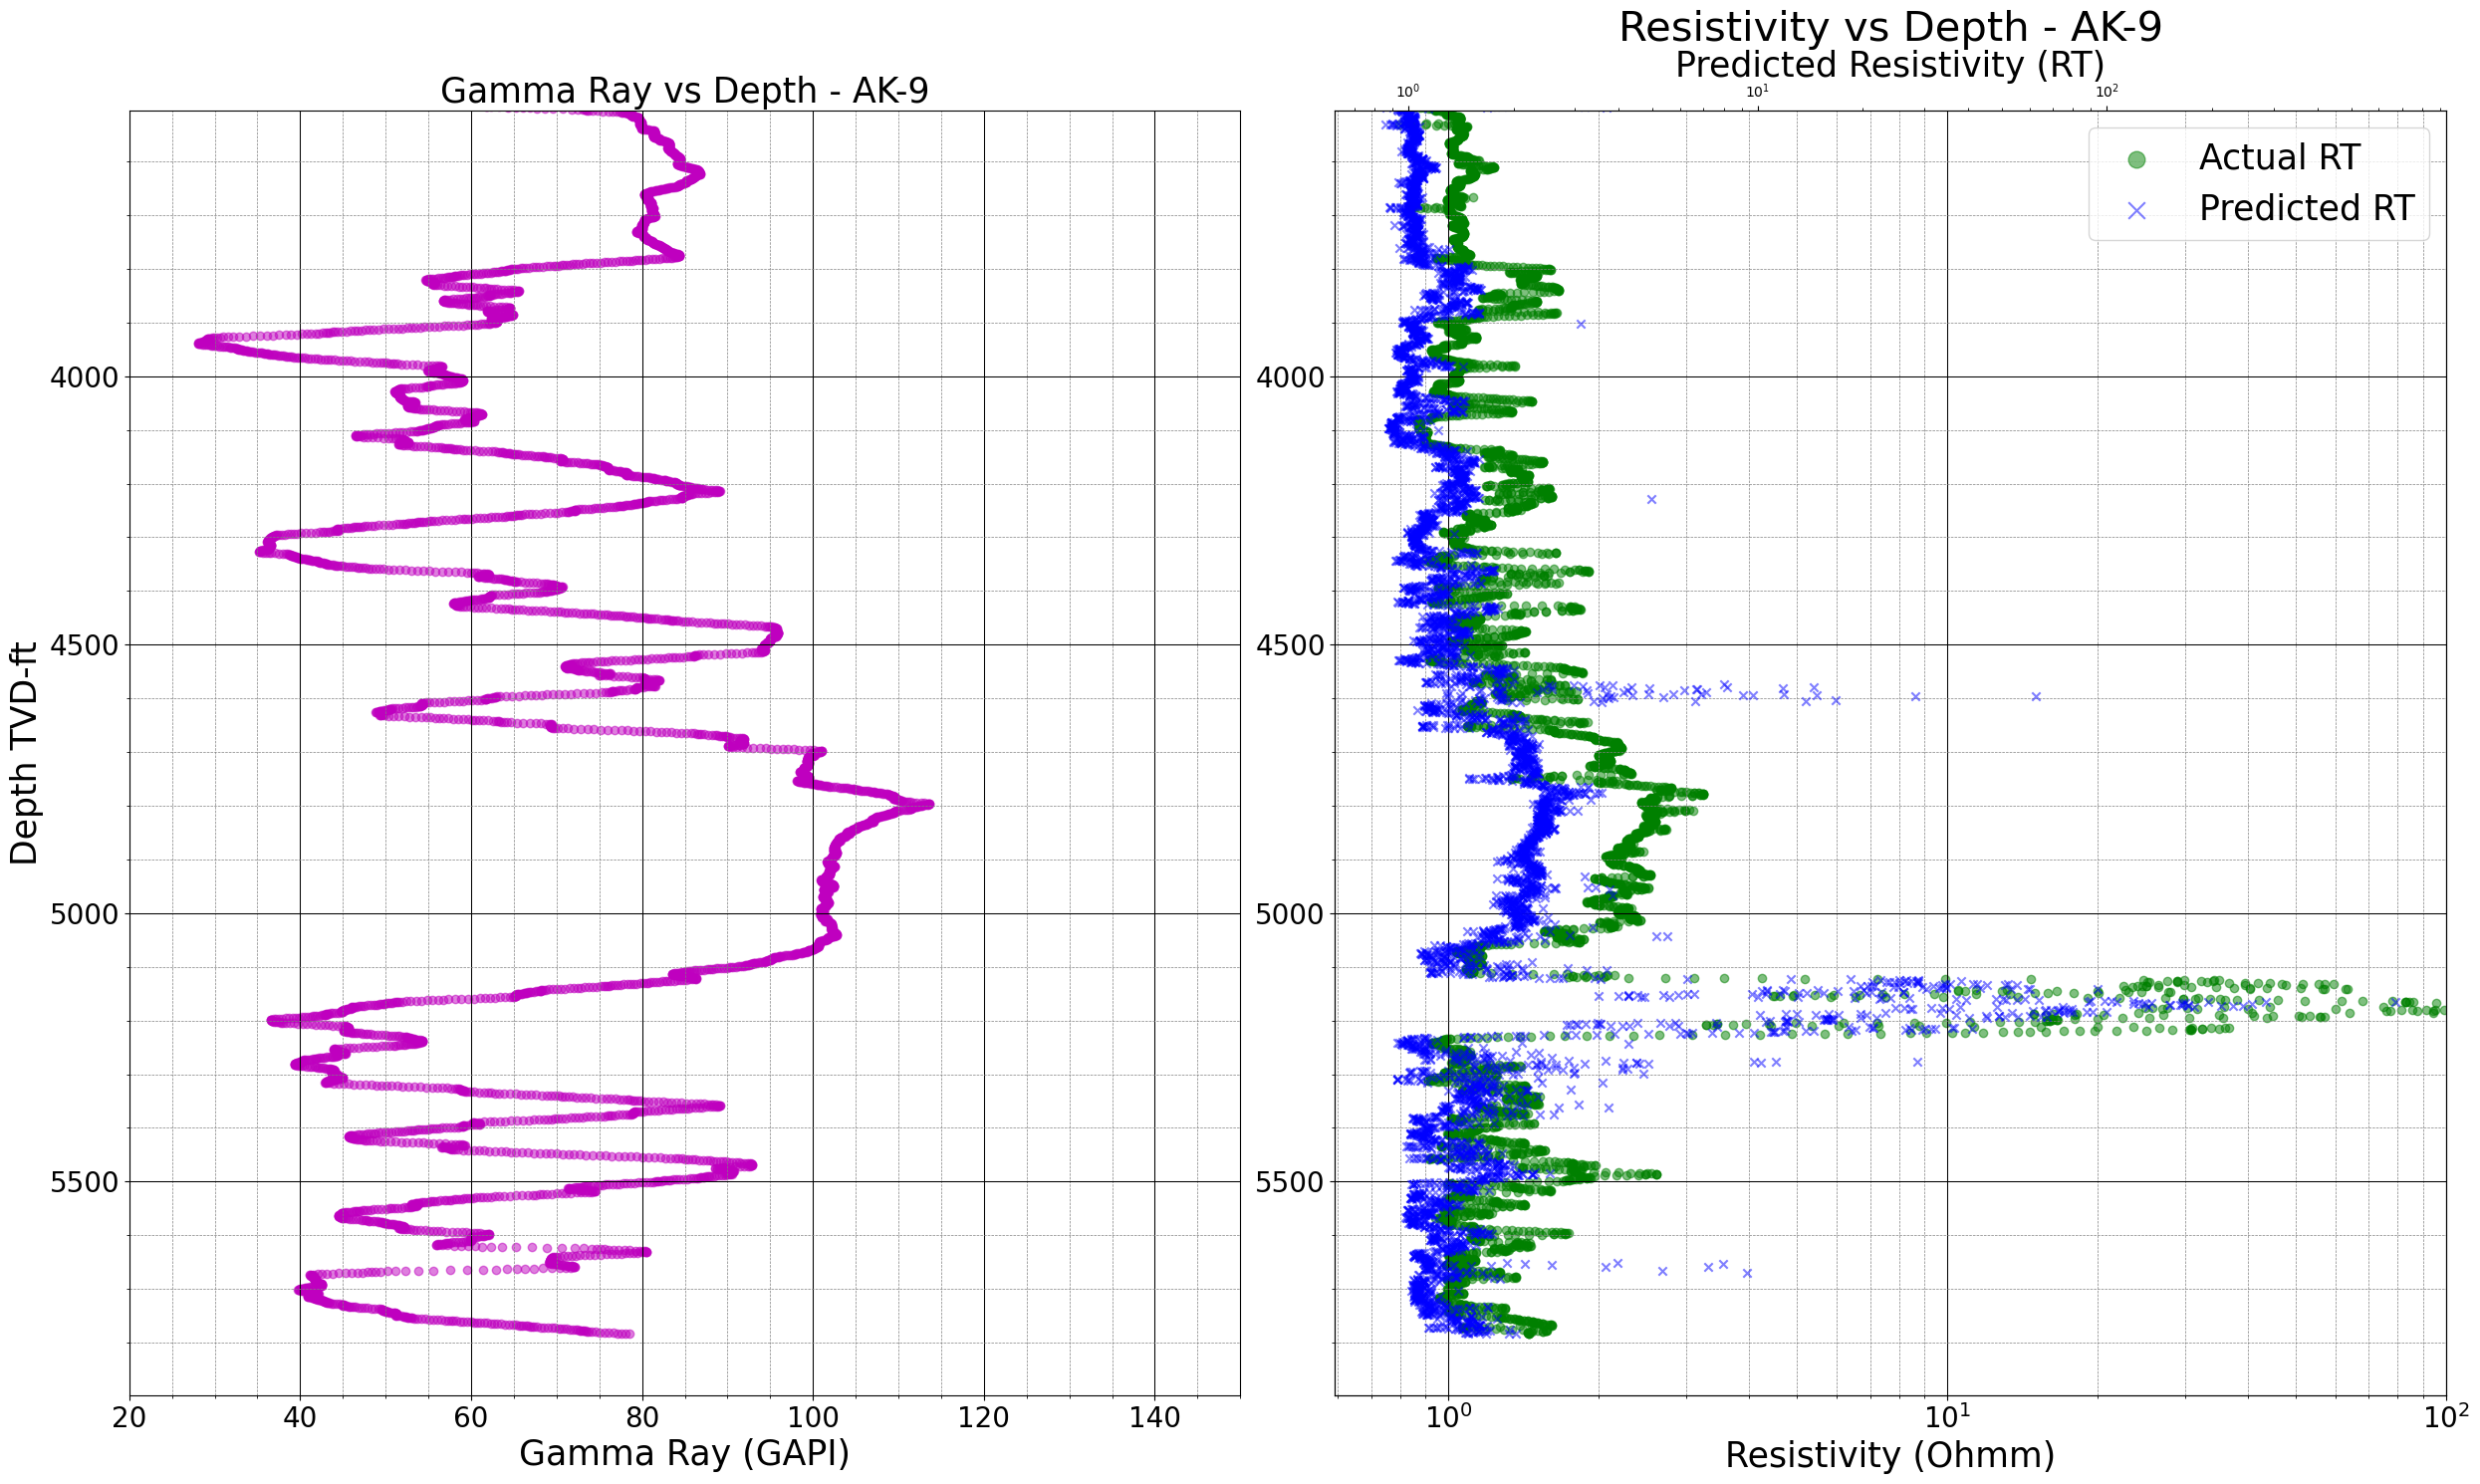

In [11]:

# ------------------------------
# Define ak9_df by reading the CSV file for well "AK-9"
# ------------------------------
ak9_filepath = os.path.join(data_directory, "AK-9.csv")
try:
    ak9_df = pd.read_csv(ak9_filepath)
except Exception as e:
    raise RuntimeError(f"Error reading AK-9 CSV file: {e}")

# Check that necessary columns exist in ak6_df.
required_columns = {'DEPT', 'GR', 'RT'}
if not required_columns.issubset(ak9_df.columns):
    raise ValueError(f"AK-9 CSV file must contain the columns: {required_columns}")

# ------------------------------
# Assume that ak9_pred_df has been obtained from predict_RT_random_forest() call.
# If not, you can alternatively predict here using a trained model.
# For demonstration, we assemble ak9_pred_df below:
# We'll assume that the prediction DataFrame must contain "DEPT" and "Predicted_RT". 
# If you already have ak9_pred_df from your previous function call, you can skip this block.
# ------------------------------
## if 'ak9_pred_df' not in globals():
    ## print("ak9_pred_df not found in globals; generating predictions using a dummy RandomForestRegressor...")
    # In case you did not run the prediction, here's a minimal example:
    # (In real usage, run predict_RT_random_forest and assign its output to model, ak9_pred_df, mse.)
    ## from sklearn.ensemble import RandomForestRegressor
    # Prepare test data from ak9_df (using only DEPT and GR, dropping rows with missing values).
    ## ak9_test = ak9_df[['DEPT', 'GR']].dropna().reset_index(drop=True)
    # For demonstration, set up a dummy model and generate random predictions.
    ## dummy_model = RandomForestRegressor()
    ## import numpy as np
    # We create dummy predictions (the same shape as ak9_test rows)
    ## dummy_predictions = np.random.uniform(low=ak9_df['RT'].min(), high=ak9_df['RT'].max(), size=len(ak9_test))
    ## ak9_pred_df = ak9_test.copy()
    ## ak9_pred_df['Predicted_RT'] = dummy_predictions
    
    
# 'smoothen' logs with a rolling mean
#window =100
#for l in list(ak9_df):
    #ak9_df[l] = pd.Series(ak9_df[l].rolling(window=window, min_periods=1).mean())

# 'smoothen' GR in original log only with a rolling mean
window =100
#for l in list(ak9_df):
ak9_df["GR"] = pd.Series(ak9_df["GR"].rolling(window=window, min_periods=1).mean())
    
# 'smoothen' logs with a rolling mean
#window =50
#for l in list(ak9_predictions):
    #ak9_predictions[l] = pd.Series(ak9_predictions[l].rolling(window=window, min_periods=1).mean())

# ------------------------------
# Create the plot.
# ------------------------------
fig, axs = plt.subplots(1, 2, figsize=(25, 15))

# Left subplot: Plot Gamma Ray vs Depth
axs[0].set_title('Gamma Ray vs Depth - AK-9', fontsize=25)
axs[0].scatter(ak9_df['GR'], ak9_df['DEPT'], color='m', alpha=0.5)
axs[0].set_xlabel('Gamma Ray (GAPI)', fontsize=25)
axs[0].set_ylabel('Depth TVD-ft', fontsize=25)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].invert_yaxis()  # Depth increases downward
axs[0].grid(which='minor', color='gray', linestyle='--', linewidth=0.5)
axs[0].grid(which='major', color='black', linestyle='-', linewidth=0.75)
axs[0].minorticks_on()
axs[0].set_xlim(20, 150)
axs[0].set_ylim(bottom=None, top=3505)

# Right subplot: Plot Resistivity vs Depth with twin axes: actual and predicted.
axs[1].set_title('Resistivity vs Depth - AK-9', fontsize=30)
# Plot actual RT (ensure you have valid values in "RT")
actual_scatter = axs[1].scatter(ak9_df['RT'], ak9_df['DEPT'], color='g', alpha=0.5, label='Actual RT')
axs[1].set_xlabel('Resistivity (Ohmm)', fontsize=25)
axs[1].set_xscale('log')  # Using log scale for RT (if applicable)
axs[1].grid(which='minor', color='gray', linestyle='--', linewidth=0.5)
axs[1].grid(which='major', color='black', linestyle='-', linewidth=0.75)
axs[1].minorticks_on()
axs[1].invert_yaxis()  # Depth increases downward

# Create a twin x-axis for predicted RT.
ax_pred = axs[1].twiny()
predicted_scatter = ax_pred.scatter(ak9_predictions['Predicted_RT'], ak9_predictions['DEPT'], 
                                    color='b', marker='x', alpha=0.5, label='Predicted RT')
ax_pred.set_xlabel('Predicted Resistivity (RT)', fontsize=25)
ax_pred.set_xscale('log')
ax_pred.grid(False)   # Disable grid for the twin axis so grid from axs[1] remains clear

axs[1].set_xlim(0,100)
axs[1].set_ylim(bottom=None, top=3505)
axs[1].tick_params(axis='both', which='major', labelsize=20)

# Merge legends from both axes.
handles1, labels1 = axs[1].get_legend_handles_labels()
handles2, labels2 = ax_pred.get_legend_handles_labels()
axs[1].legend(handles1 + handles2, labels1 + labels2, loc='upper right', fontsize=25, markerscale=2)

plt.tight_layout()
plt.show()
